In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
import numpy as np
import k3d
import matplotlib.pyplot as plt
from functools import reduce
from raytracing import *

In [3]:
def LensCav(arm1=50., arm2=55., base=19., angle=np.deg2rad(150), lens_dist=11.075, lens_diam=6.35, lens_thick=4., Rlens=5.0, eps=np.zeros((6,5))):
    
    p0 = np.array([lens_dist/2.-lens_thick/2.,0,0])
    p1 = np.array([lens_dist/2.+lens_thick/2.,0,0])
    p2 = np.array([arm1/2.,0,0])
    p3 = np.array([np.cos(angle)*arm2/2.,base,np.sin(angle)*arm2/2.])
    p4 = np.array([-np.cos(angle)*arm2/2.,base,-np.sin(angle)*arm2/2.])
    p5 = np.array([-arm1/2.,0,0])
    p6 = np.array([-lens_dist/2.-lens_thick/2.,0,0])
    p7 = np.array([-lens_dist/2.+lens_thick/2.,0,0])

    
    ps = np.stack([p0,p1,p2,p3,p4,p5,p6,p7], axis=0)
    geom = geometry(ps)
    ns = geom['refl']
    for i in range(ns.shape[0]):
        ns[i,:] = -norm(ns[i,:])
    #fix normal vectosfor transmission
    ns[0,:] = np.array([-1,0,0])
    ns[1,:] = np.array([-1,0,0])
    ns[6,:] = np.array([1,0,0])
    ns[7,:] = np.array([-1,0,0])
    ps = geom['mir']
    #add perturbations
    ps[2:6] += eps[2:6,:3]
    #lenses special FIX translation and rotation!
    ps[0] += eps[0,:3]
    ps[1] += eps[0,:3]
    ps[6] += eps[5,:3]
    ps[7] += eps[5,:3]
    axx = geom['xin']
    axy = 0.5*(geom['yin']+geom['yout'])
    #ns[2:6] = [rot_vec(rot_vec(ns[i], axx[i], np.deg2rad(eps[i,3])), axy[i], np.deg2rad(eps[i,4])) for i, n in enumerate(ns[2:6])]
    ns[2] = rot_vec(rot_vec(ns[2], axx[2], np.deg2rad(eps[1,3])), axy[2], np.deg2rad(eps[1,4]))
    ns[3] = rot_vec(rot_vec(ns[3], axx[3], np.deg2rad(eps[2,3])), axy[3], np.deg2rad(eps[2,4]))
    ns[4] = rot_vec(rot_vec(ns[4], axx[4], np.deg2rad(eps[3,3])), axy[4], np.deg2rad(eps[3,4]))
    ns[5] = rot_vec(rot_vec(ns[5], axx[5], np.deg2rad(eps[4,3])), axy[5], np.deg2rad(eps[4,4]))
    #lenses special
    ns[0] = rot_vec(rot_vec(ns[0], axx[0], np.deg2rad(eps[0,3])), axy[0], np.deg2rad(eps[0,4]))
    ns[1] = rot_vec(rot_vec(ns[1], axx[1], np.deg2rad(eps[0,3])), axy[1], np.deg2rad(eps[0,4]))
    ns[6] = rot_vec(rot_vec(ns[6], axx[6], np.deg2rad(eps[5,3])), axy[6], np.deg2rad(eps[5,4]))
    ns[7] = rot_vec(rot_vec(ns[7], axx[7], np.deg2rad(eps[5,3])), axy[7], np.deg2rad(eps[5,4]))
    
    
    hi = 12.7
    qi=7.75
    ng = 1.41
    elements = [Glass(p=ps[0], n=ns[0], diam=lens_diam, n2=ng),\
                CurvedGlass(p=ps[1], n=ns[1], diam=lens_diam, R=Rlens, curv='CC', n1=ng),\
                Mirror(p=ps[2], n=ns[2], diam=hi),\
                Mirror(p=ps[3], n=ns[3], diam=hi),\
                Mirror(p=ps[4], n=ns[4], diam=hi),\
                Mirror(p=ps[5], n=ns[5], diam=hi),\
                CurvedGlass(p=ps[6], n=ns[6], diam=lens_diam, R=Rlens, curv='CC', n1=ng),\
                Glass(p=ps[7], n=ns[7], diam=lens_diam, n1=ng),\
               ]
    return elements, geom

In [4]:
elements, geom = LensCav()

x0 = 0.5*(elements[0].p + elements[-1].p)
n0 = norm(elements[0].p - elements[-1].p)

screen = Screen(p=x0, n=-n0, diam=7.75)
elements.append(screen)

C:\Users\lukas\Box\Lukas\03_Theory\ABCD\Raytracing\raytracing.py:25: RuntimeWarning: invalid value encountered in true_divide
  return v/np.linalg.norm(v)


In [5]:
#debug
opt = elements[6]
#opt.n = -opt.n
rays = ray_bundle(n=-opt.n, p=opt.p+5*opt.n, n_radii=5, n_angles=3, divergence=0, R=1.)
#rays = ray_bundle(n=opt.n, p=opt.p-5*opt.n, n_radii=5, n_angles=3, divergence=0, R=1.4)
rays2 = opt.propagate(rays)

In [10]:
try:
    plot.close()
except:
    pass
plot = k3d.plot(camera_auto_fit=True, antialias=True)

plot_rays(rays, plot, color=0x00ff00)
plot_rays(rays2, plot, color=0x00ff00)
plot += opt.plot()
plot.display()

Output()

In [188]:
#r0 = x0[None,:] + np.array([[0,0.2,0], [0,0,0.2], [0,0.2,0.2], [0,-0.2,-0.2]])
#s0 = np.broadcast_to(n0, r0.shape)
#r0, s0 = x0 + np.array([0,0,0]), norm(n0 + np.array([0,0,0]))
r0, s0 = x0 , n0
ray0 = np.stack([np.atleast_2d(r0), np.atleast_2d(s0)], axis=0)

In [199]:
reig, traj_anim = find_eigenray_animated(elements, rayp, lr=2e-3, debug=True, clip=False)
ts_dicts = traj_to_timeseries(traj_anim)

Failed
Finished in 197 steps, reached tol 2.998e+02


TypeError: tuple indices must be integers or slices, not tuple

In [214]:
try:
    plot.close()
except:
    pass
plot = k3d.plot(camera_auto_fit=True, antialias=True)
#plot += k3d.vectors(origins=x0, vectors=n0)

for el in elements:
    plot += el.plot(opacity=0.4)
    plot += k3d.vectors(origins=el.p, vectors=el.p, color=0xffff00)

#plot_trajs(traj, plot)
#for ts in ts_dicts:
#    plot += k3d.line(ts, shader='mesh', width=0.1, color=0x00ff00)
plot += k3d.vectors(origins=rayp[0,0,:], vectors=rayp[1,0,:], color=0xff0000)

plot.display()

C:\ProgramData\Anaconda3\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [215]:
elements[-1].n

array([-1., -0., -0.])

In [220]:
elements[7].n

array([-1.,  0.,  0.])

In [116]:
reig = ray0

In [127]:
traj_eig = propagate_system(elements, ray0, Nrt=1)[:,0,:,:]

In [138]:
rp, sp = x0 + np.array([0,1e-2,0]), norm(n0 + np.array([0,0,0]))
#rp, sp = x0 , n0
rayp = np.stack([np.atleast_2d(rp), np.atleast_2d(sp)], axis=0)

In [205]:
rayp = ray_bundle(n=(1,0,0), n_radii=3, n_angles=3, divergence=1e-3, R=0.)

In [185]:
elements_clp = elements#[:-2]

In [186]:
traj_p= propagate_system(elements_clp, rayp, Nrt=1, clip=True)

In [187]:
try:
    plot.close()
except:
    pass
plot = k3d.plot(camera_auto_fit=True, antialias=True)
for el in elements:
    plot += el.plot(opacity=0.4)

plot_trajs(traj_p, plot)
plot.display()

Output()

In [128]:
#visualize perturbed mode
which=0
ax=2
amp = 1e-3
dists, trajs_pert, modelmats = perturb_one_anim(LensCav, screen, reig, traj_eig, which=which, ax=ax, rng=np.linspace(-amp, amp, 30))

In [129]:
trajs_pert_ts = traj_to_timeseries(trajs_pert, step=1)
modelmats_ts = modelmats_to_timeseries(modelmats, step=1)

In [130]:
plot = k3d.plot(camera_auto_fit=True, antialias=True)

for i, el in enumerate(elements[:-1]):
    pel = el.plot(opacity=0.4)
    if i==which:
        pel.color=0xff0000
    pel.model_matrix = modelmats_ts[i]
    plot += pel

#plot_trajs(traj, plot)
for ts in trajs_pert_ts:
    plot += k3d.line(ts, shader='mesh', width=0.2, color=0x00ff00)

plot.display()

Output()

In [131]:
plot.start_auto_play()

In [132]:
plot.stop_auto_play()
plot.close()

In [150]:
#Poincare hit pattern

In [111]:
elements, _ = LensCav()

x0 = 0.5*(elements[0].p + elements[-1].p)
n0 = norm(elements[0].p - elements[-1].p)

screen = Screen(p=x0, n=-n0, diam=7.75)
elements.append(screen)

# 27.8, 0.2r0, -2e-2 s0 10 iter
#27.77 0.1 -2e-3 10

r0 = x0[None,:] + np.array([0,0.001,0])
s0 = n0[None,:] + np.array([0,-1e-5*0,0])
#s0 = np.broadcast_to(n0, r0.shape)

ray0 = np.stack([np.atleast_2d(r0), np.atleast_2d(s0)], axis=0)

reig3, traj_anim3 = find_eigenray_animated(elements, ray0, lr=0.001, Nrt=3, debug=True, maxiter=50)

ts3_dicts = traj_to_timeseries(traj_anim3)

Failed


UnboundLocalError: local variable 'res' referenced before assignment

C:\Users\lukas\Box\Lukas\03_Theory\ABCD\Raytracing\raytracing.py:202: RuntimeWarning: invalid value encountered in sqrt
  t12 = np.stack([ds+np.sqrt(dis), ds-np.sqrt(dis)], axis=0) #[2xNrays]
C:\Users\lukas\Box\Lukas\03_Theory\ABCD\Raytracing\raytracing.py:211: RuntimeWarning: invalid value encountered in less_equal
  msk[msk] = (d<=self.intersect_d)


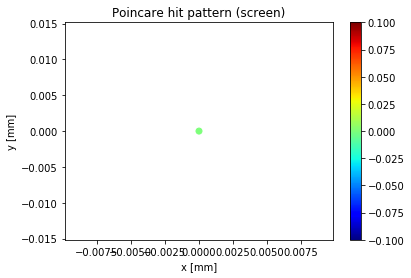

In [109]:
#traj_hit = propagate_system(elements, reig3, Nrt=2000)[:,0,:,:] #only positions
#hit_scr = traj_hit[9::9,0,:]
traj_hit = propagate_system_at(elements, reig3, which=8, Nrt=2000)[:,0,:,:] #only positions
hit_scr = traj_hit[:,0,:]
hit_idx = np.arange(hit_scr.shape[0])

plt.figure()
plt.scatter(hit_scr[:,1], hit_scr[:,2], c=hit_idx, cmap='jet')
plt.title('Poincare hit pattern (screen)')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.colorbar()
plt.show()

In [243]:
plot = k3d.plot(camera_auto_fit=True, antialias=True)

for el in elements:
    plot += el.plot(opacity=0.4)

for ts in ts3_dicts:
    plot += k3d.line(ts, shader='mesh', width=0.2, color=0x00ff00)

plot.display()
plot.start_auto_play()

Output()

In [96]:
%matplotlib inline